In [1]:
# imports
#bigqueryhelper
from google.cloud import bigquery
import pandas as pd
import numpy as np
import plotly
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# API key verification for Google Cloud
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/davidhofhuizen/Projects/EDA_Bitcoin-ledger/rugged-ether-350608-2a8031aeb288.json"
client = bigquery.Client()

Functions

In [3]:
def run_query(query):
    query_job = client.query(query)

    iterator = query_job.result(timeout=120000)
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    result = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    
    return result
    
def balance_transform(value):
    return value / 100000000

In [4]:
query =  '''
WITH double_entry_book AS (
    -- debits
    SELECT
     array_to_string(inputs.addresses, ",") as address
    , inputs.type
    , -inputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
 
    UNION ALL
 
    -- credits
    SELECT
     array_to_string(outputs.addresses, ",") as address
    , outputs.type
    , outputs.value as value
    , block_timestamp
    FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
,double_entry_book_by_date as (
    select 
        date(block_timestamp) as date, 
        address, 
        sum(value / POWER(10,0)) as value
    from double_entry_book
    group by address, date
)
,daily_balances_with_gaps as (
    select 
        address, 
        date,
        sum(value) over (partition by address order by date) as balance,
        lead(date, 1, current_date()) over (partition by address order by date) as next_date
        from double_entry_book_by_date
)
,calendar as (
    select date from unnest(generate_date_array('2009-01-12', current_date())) as date
)
,daily_balances as (
    select address, calendar.date, balance
    from daily_balances_with_gaps
    join calendar on daily_balances_with_gaps.date <= calendar.date and calendar.date < daily_balances_with_gaps.next_date
)
,supply as (
    select
        date,
        sum(balance) as daily_supply
    from daily_balances
    group by date
)
,ranked_daily_balances as (
    select 
        daily_balances.date,
        balance,
        row_number() over (partition by daily_balances.date order by balance desc) as rank
    from daily_balances
    join supply on daily_balances.date = supply.date
    where safe_divide(balance, daily_supply) >= 0.0001
    ORDER BY safe_divide(balance, daily_supply) DESC
)

select 
    date, 
    -- (1 − 2B) https://en.wikipedia.org/wiki/Gini_coefficient
    1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini
from ranked_daily_balances
group by date
order by date asc
'''

In [5]:
test = '1 - 2 * sum((balance * (rank - 1) + balance / 2)) / count(*) / sum(balance) as gini,'

In [6]:
query1 = '''
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
SELECT address, type, sum(value) as balance
FROM double_entry_book
GROUP BY address, type
ORDER BY balance DESC
LIMIT 200000
'''

In [7]:
query2 = '''
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
SELECT COUNT(DISTINCT address) as unique_addresses
FROM double_entry_book
GROUP BY address, type
'''

In [8]:
balances = run_query(query1)
balances['balance'] = balances['balance'].apply(balance_transform)

In [9]:
balances[:100]['balance'].sum()

Decimal('2974564.32776816')

In [10]:
balance_top_200000 = float(balances['balance'].sum())

In [11]:
active_addresses = 897647

In [12]:
total_bitcoins = 19072456.25

In [13]:
remaining_bitcoins = total_bitcoins - balance_top_200000
remaining_addresses = active_addresses - 200000

In [14]:
balance_transform(remaining_bitcoins * remaining_addresses)

17628.902926736984

In [15]:
def get_market_share(value):
    value = float(value)
    percentage = (value / total_bitcoins) * 100

    print(percentage)

    return np.power(percentage, 2)

In [16]:
get_market_share(float(balances[:10000]['balance'].sum()))

58.5711223650496


3430.576375101613

In [17]:
2981920.45663931 / total_bitcoins

0.15634695487317266

In [18]:
balances['hhi'] = balances['balance'].apply(get_market_share)

1.324408524332832
0.8809037682136511
0.6828042605040974
0.6572364619228842
0.5309541606629717
0.4962302880971611
0.4955069275941844
0.4192287402272059
0.363719154520226
0.344718092576356
0.33713539201590775
0.2831709807612745
0.2825019570182524
0.2717552282040757
0.26541007566018143
0.261244399338706
0.23069963162594748
0.2042861360839142
0.1988573312108135
0.19429412280869698
0.19397985387959665
0.18875604197230755
0.1786186877344128
0.17062525790006727
0.16946427648562573
0.16591141586784344
0.163981741322175
0.1625384283363083
0.15206148050495594
0.1488646685233319
0.1476005934592195
0.1290023144963303
0.12843311902052468
0.12678239901334154
0.1256733859250562
0.12231311045440203
0.12174624859868273
0.12006838623908234
0.10842710793241433
0.10557756756117871
0.10490521872084514
0.1017930278798254
0.09752308668832312
0.08913608890144918
0.08801148115440033
0.08627782063728683
0.08556931516012785
0.08549788403609525
0.08321418426113836
0.08267473469365016
0.08255651926856562
0.0794913

In [19]:
balances

address  \
0                      34xp4vRoCGJym3xR7yCVPFHoCNxv4Twseo   
1       bc1qgdjqv0av3q56jvd82tkdjpy7gdp9ut8tlqmgrpmv24...   
2                      1P5ZEDWTKTFGxQjZphgWPQUpe554WKDfHQ   
3                      3LYJfcfHPXYJreMsASk2jkn69LWEYKzexb   
4                      3M219KR5vEneNb47ewrPfWyb5jQ2DjxRP6   
...                                                   ...   
199995                 1QGsxcsSAEcSP4Zvupfj5YWNyqLf9kTXQv   
199996                 3DF4dYNkojSNsNrQXbf13JccDXGFtHadxm   
199997                 19oaCKtAaqnHHuPCYbRiFEtuRRYwvwdHmf   
199998                 1MxGtTVG7y16J1HB3W6ybkmgGiE3BaxZBu   
199999                 1KaNc9oQuy4LLbFj4Npk5ShokN8nGDziTp   

                         type          balance   hhi  
0                  scripthash  252597.23637465 1.754  
1       witness_v0_scripthash  168009.98579715 0.776  
2                  pubkeyhash  130227.54385778 0.466  
3                  scripthash  125351.13665929 0.432  
4                  scripthash           101266 0.282  
...                       ...              ...   ...  
199995             pubkeyhash       6.06465027 0.000  
199996             scripthash       6.06456055 0.000  
199997             pubkeyhash       6.06450002 0.000  
199998             pubkeyhash       6.06446261 0.000  
199999             pubkeyhash       6.06444063 0.000  

[200000 rows x 4 columns]

In [20]:
balances['hhi'].sum()

6.616380953403089

In [21]:
miner_data = pd.read_csv('bitcoin.csv')

In [22]:
miner_data.columns

Index(['date', 'txVolume(USD)', 'adjustedTxVolume(USD)', 'txCount',
       'marketcap(USD)', 'price(USD)', 'exchangeVolume(USD)', 'generatedCoins',
       'fees', 'activeAddresses', 'averageDifficulty', 'paymentCount',
       'medianTxValue(USD)', 'medianFee', 'blockSize', 'blockCount'],
      dtype='object')

In [23]:
total_coins = miner_data[['date', 'generatedCoins']]
total_coins['date'] = pd.to_datetime(total_coins['date'])
total_coins['cumulative'] = total_coins['generatedCoins'].cumsum()

/Users/davidhofhuizen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/davidhofhuizen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
total_coins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3605 entries, 0 to 3604
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            3605 non-null   datetime64[ns]
 1   generatedCoins  3605 non-null   float64       
 2   cumulative      3605 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 84.6 KB


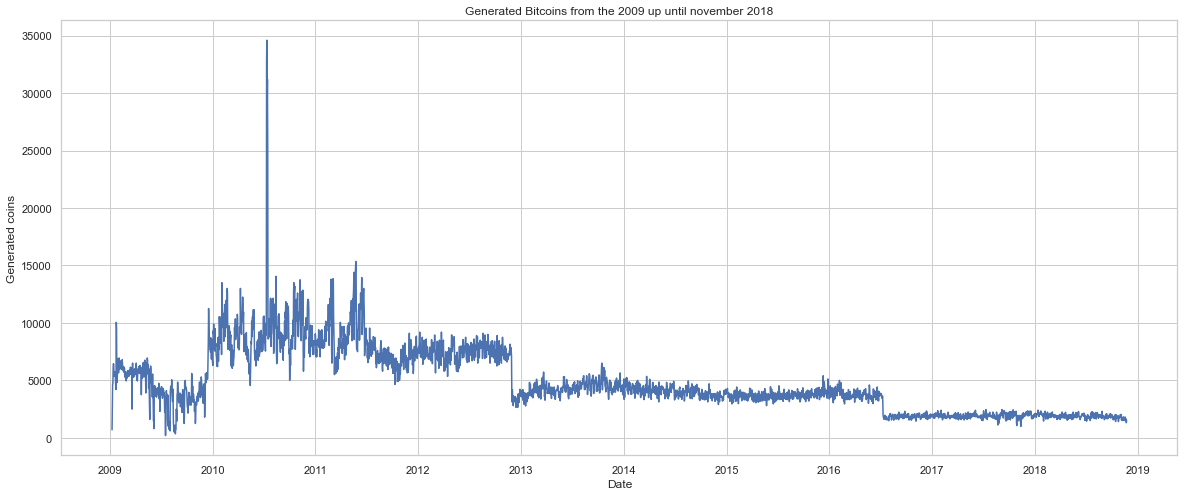

In [52]:
plt.figure(figsize = [20,8])
plt.title('Generated Bitcoins from the 2009 up until november 2018')
plt.xlabel("Date")
plt.ylabel("Generated coins")
plt.plot(total_coins['date'], total_coins['generatedCoins'])
plt.show()

In [26]:
x = total_coins['date']
y = total_coins['cumulative']

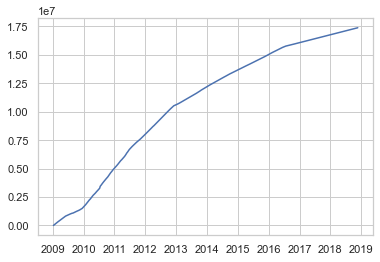

In [27]:
plt.plot(x,y)
plt.show()

In [50]:
def get_addresses(years):
    #address_list = pd.DataFrame(columns = ['address'])
    address_list = []

    for year in years:
        

        df = pd.read_csv(f'Top200_{year}.csv')
        addresses = list(df['address'])

        address_list.extend(addresses)

    address_list = list(set(address_list))

    return address_list

def get_transactions(adopters):
    wealth_development = f"""
    WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value, DATE(block_timestamp) as date
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
    )
    SELECT address, type, sum(value) as balance, date, EXTRACT(YEAR FROM date) as year
    FROM double_entry_book
    where address IN {adopters}
    GROUP BY date, address, type
    ORDER BY balance DESC
    """

    df = run_query(wealth_development)

    return df

def transaction_processing(df_old):
    df = df_old.copy()

    df['balance'] = df['balance'].astype('int')
    df['date'] = pd.to_datetime(df['date'])
    df['balance'] = df['balance'].apply(balance_transform)
    df = df.rename(columns = {'date' : 'transaction_date', 'type': 'address_type', 'balance': 'amount'})
    
    return df

def balance_transform(value):
    return value / 100000000

        

In [29]:
early_adopters = get_addresses(list(range(2009,2016)))

In [30]:
len(early_adopters)

1377

In [31]:
early_adopter_transactions = get_transactions(tuple(early_adopters))

cumulative_balance_over_time = early_adopter_transactions_processed.copy()[['date', 'balance']].sort_values(by= 'date')
cumulative_balance_over_time['cumulative_balance'] = cumulative_balance_over_time['balance'].cumsum()

In [51]:
early_adopter_transactions_processed = transaction_processing(early_adopter_transactions)
early_adopter_transactions_processed


address address_type      amount  \
0      1JoktQJhCzuCQkt3GnQ8Xddcq4mUgNyXEa   pubkeyhash  217517.634   
1      1EFJUipfCHFmmTFkF9vvjFKdBf3VbfvarM   pubkeyhash  182838.401   
2      1FfmbHfnpaZjKFvyi1okTjJJusN455paPH   pubkeyhash  144336.397   
3      3HyULbPVM739jPVk4i3PKZ4LibhYP1HsLc   scripthash  134173.148   
4      1JEC8vYP9cEDSu6N6DXkkYd3RaeWAdsCqN   pubkeyhash  119541.314   
...                                   ...          ...         ...   
63530  1JoktQJhCzuCQkt3GnQ8Xddcq4mUgNyXEa   pubkeyhash -125063.819   
63531  13Df4x5nQo7boLWHxQCbJzobN5gUNT65Hh   pubkeyhash -134173.148   
63532  1FfmbHfnpaZjKFvyi1okTjJJusN455paPH   pubkeyhash -144341.536   
63533  1EFJUipfCHFmmTFkF9vvjFKdBf3VbfvarM   pubkeyhash -183497.401   
63534  1JEC8vYP9cEDSu6N6DXkkYd3RaeWAdsCqN   pubkeyhash -205980.634   

      transaction_date  year  
0           2014-12-02  2014  
1           2014-05-24  2014  
2           2013-10-25  2013  
3           2014-11-28  2014  
4           2014-11-13  2014  
...                ...   ...  
63530       2015-01-21  2015  
63531       2014-11-28  2014  
63532       2014-06-12  2014  
63533       2014-05-30  2014  
63534       2014-12-02  2014  

[63535 rows x 5 columns]

In [32]:
cumulative_balance_over_time.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63535 entries, 19780 to 59405
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                63535 non-null  datetime64[ns]
 1   balance             63535 non-null  float64       
 2   cumulative_balance  63535 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.9 MB


In [33]:
max_date = total_coins.date.max()
max_date

Timestamp('2018-11-22 00:00:00')

In [34]:
cumulative_balance_over_time

date  balance  cumulative_balance
19780 2009-01-10   50.000              50.000
18132 2009-01-14   61.000             111.000
19576 2009-01-15   50.000             161.000
9386  2009-01-15  250.000             411.000
19507 2009-01-16   50.000             461.000
...          ...      ...                 ...
24328 2022-06-24   16.734          588280.811
33278 2022-06-25    0.003          588280.814
25739 2022-06-25   10.670          588291.484
54369 2022-06-26  -83.368          588208.116
59405 2022-06-26 -850.002          587358.114

[63535 rows x 3 columns]

In [35]:
joined_df =pd.merge(total_coins[total_coins['date'] > '2009-01-09'], cumulative_balance_over_time[cumulative_balance_over_time['date'] < max_date], on = 'date')

In [36]:
joined_df['share'] = joined_df['cumulative_balance'] / joined_df['cumulative'] * 100

In [37]:
joined_df

date  generatedCoins   cumulative  balance  cumulative_balance  \
0     2009-01-10        3050.000     3750.000   50.000              50.000   
1     2009-01-14        6450.000    25700.000   61.000             111.000   
2     2009-01-15        6300.000    32000.000   50.000             161.000   
3     2009-01-15        6300.000    32000.000  250.000             411.000   
4     2009-01-16        5400.000    37400.000   50.000             461.000   
...          ...             ...          ...      ...                 ...   
57744 2018-11-21        1312.500 17387333.545    0.000         1713867.163   
57745 2018-11-21        1312.500 17387333.545    1.013         1713868.176   
57746 2018-11-21        1312.500 17387333.545  -16.384         1713851.792   
57747 2018-11-21        1312.500 17387333.545   12.945         1713864.736   
57748 2018-11-21        1312.500 17387333.545    0.001         1713864.737   

       share  
0      1.333  
1      0.432  
2      0.503  
3      1.284  
4      1.233  
...      ...  
57744  9.857  
57745  9.857  
57746  9.857  
57747  9.857  
57748  9.857  

[57749 rows x 6 columns]

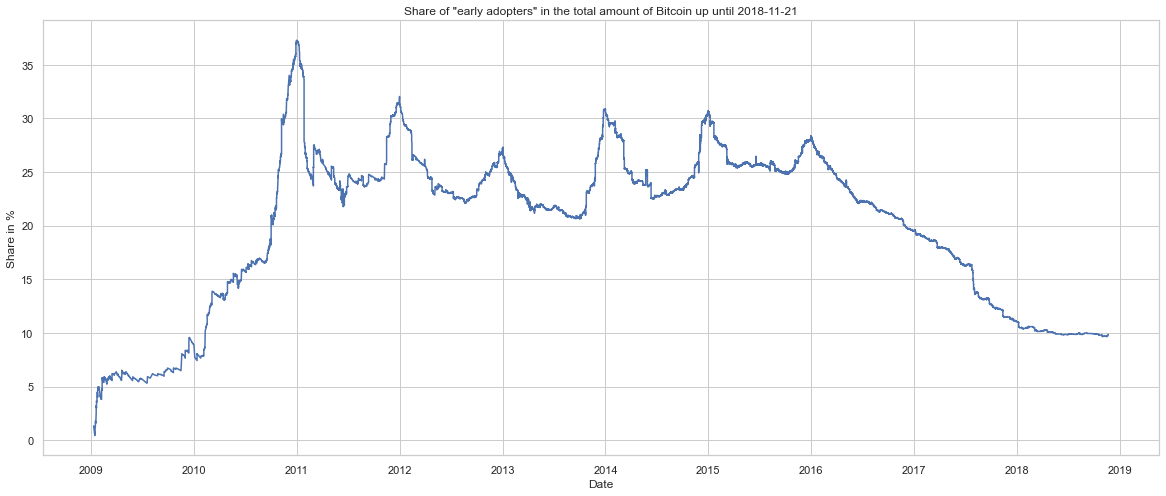

In [38]:
plt.figure(figsize = [20,8])
plt.title('Share of "early adopters" in the total amount of Bitcoin up until 2018-11-21')
plt.ylabel('Share in %')
plt.xlabel('Date')
plt.plot(joined_df.date, joined_df.share)
plt.show()

In [39]:
%store -r miner_addresses

In [40]:
early_adopter_miner = [i for i, j in zip(early_adopters, miner_addresses) if i == j]

In [41]:
len(early_adopter_miner)

0

In [42]:
miner_transactions = get_transactions(tuple(miner_addresses))
miner_transactions_processed = transaction_processing(miner_transactions)
cumulative_balance_over_time_miner = miner_transactions_processed.copy()[['date', 'balance']].sort_values(by= 'date')
cumulative_balance_over_time_miner['cumulative_balance'] = cumulative_balance_over_time_miner['balance'].cumsum()

In [43]:
joined_df_miner =pd.merge(total_coins[total_coins['date'] > '2009-01-09'], cumulative_balance_over_time_miner[cumulative_balance_over_time_miner['date'] < max_date], on = 'date')
joined_df_miner['share'] = joined_df_miner['cumulative_balance'] / joined_df_miner['cumulative'] * 100

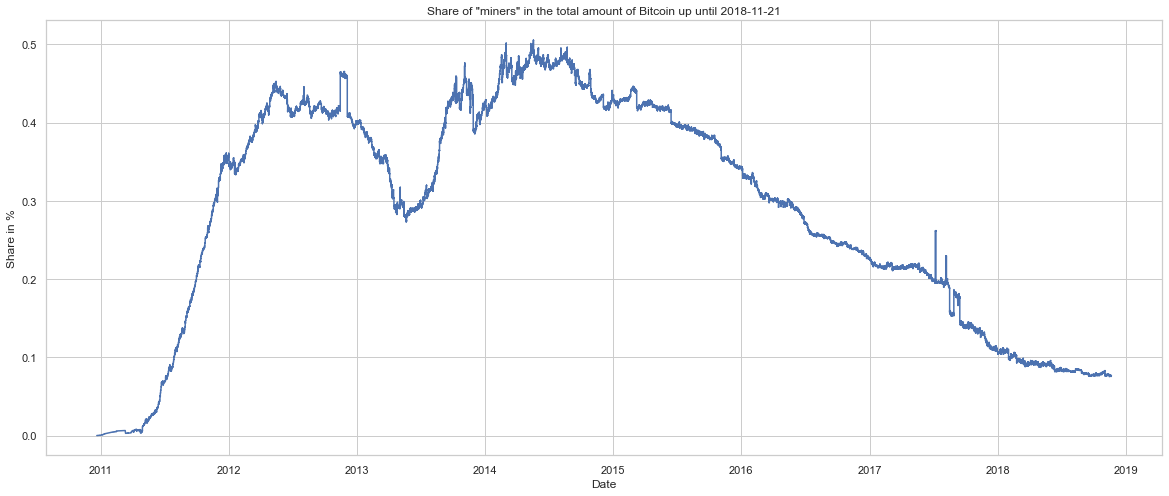

In [44]:
plt.figure(figsize = [20,8])
plt.title('Share of "miners" in the total amount of Bitcoin up until 2018-11-21')
plt.ylabel('Share in %')
plt.xlabel('Date')
plt.plot(joined_df_miner.date, joined_df_miner.share)
plt.show()

In [45]:
toponepercent = '''
WITH double_entry_book AS (
   -- debits
   SELECT array_to_string(inputs.addresses, ",") as address, inputs.type, -inputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.inputs` as inputs
   UNION ALL
   -- credits
   SELECT array_to_string(outputs.addresses, ",") as address, outputs.type, outputs.value as value
   FROM `bigquery-public-data.crypto_bitcoin.outputs` as outputs
)
SELECT address, type, sum(value) as balance
FROM double_entry_book
GROUP BY address, type
ORDER BY balance DESC
LIMIT 7270
'''

In [46]:
onepercent = run_query(toponepercent)

In [47]:
onepercent['balance'].apply(balance_transform).sum()

Decimal('10620504.49278372')